
# Mini-project 1, DSC 170, Fall 2020
## Geometric manipulations in Geopandas, projections, creating maps


In this mini-project, you will be looking for three relatively large parks closest to UCSD's CSE Department building. More generally, you'll be writing a function that returns N polygons, each of which has area A or larger, for an arbitrary point specified in Latitude and Longitude. In addition, you will plot the selected parks on a map, along with the arbitrary point, and distance buffers around the point. You may then also call folium to show the same data as an interactive map.

You will be working with geopandas, pandas, shapely, and folium.

In [2]:
%matplotlib inline 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium

### Part 1 (10 points)

We will begin by creating a function `closest_polys` which generates a geodataframe containing the nearest polygons (of a particular area) to a point. 

This function takes in as input:
* `point_lat` and `point_lon`: coordinates for an arbitrary point of interest.
* `polys_gdf`: geopandas geodataframe, which you instantiate with the San Diego parks data from SanDAG (feel free to  use the copy we already downloaded and used in the lecture, or download from https://sandag.org directly)

* `area_field`: the field (column) name in the dataframe you will use to select polygons based on their size (in our case, this field is 'GIS_ACRES')  

* `area_field_unit`: the field unit that will be used (i.e. area_field_unit='acre')
* `min_area_miles`: the minimum size of the park we are interested in, in square miles. Let's say, we are interested in parks which are 0.5 sq miles or larger
* `number_of_polys`: the number of the closest parks to return. Let's say we are interested in 3 parks. 

To be returned:
* geopandas geodataframe for the N selected parks
* geopandas geodataframe for the point of interest (we need that to enter in the next function.)

Note the following considerations:
* Add comments to each step in your code
* For the CSE Department building, you can find the latitude and longitude using Google maps, geojson.io, or other sources. 
* An arbitrarily selected point may be within a park (even on a park boundary - though that is not too likely), but this park may not satisfy the size criteria
* Be careful about projections used for different data frames, and distance units. Geometric operations would only make sense if the different data frames are in the same projection, and the distance units are those recognized by the projection. You will have to convert between miles, feet, sqmiles, acres, etc. Note that San Diego data are in California State Plane Zone 6 - see http://spatialreference.org/ref/epsg/nad83-california-zone-6-ftus/. It is epsg:2230 (really, you should figure this out using geopandas.)

In [3]:
# YOUR CODE HERE
def closest_polys(point_lat, point_lon, polys_gdf, area_field, area_field_unit, min_area_miles, number_of_polys):
    #Create geodataframe for point of interest
    point = gpd.GeoSeries([Point(point_lon, point_lat)])
    gdf_point = gpd.GeoDataFrame(point)
    gdf_point.geometry = point
    gdf_point['Name'] = 'Arbitrary Point'
    #make sure both are in lon and lat format first
    gdf_point.crs = "EPSG:4326"
    polys_gdf = polys_gdf.to_crs(4326)
    
    #Convert units to square miles
    unit_conv = {'acre': 640, 'sqmiles': 1, 'sqft': 27878400} #these are converted to SQ MILES
    polys_gdf[area_field] = polys_gdf[area_field] / unit_conv[area_field_unit]
    polygons = polys_gdf[polys_gdf[area_field] >= min_area_miles]
    #Convert to same CRS
    polygons_2230 = polygons.to_crs(2230)
    point_2230 = gdf_point.to_crs(2230)
    #Make sure arbitrary point is not in the polygon
    polygons_2230 = polygons_2230[point_2230.touches(polygons_2230) == False]
    #Get the N closest polygons using distance().
    distances = polygons_2230.distance(point_2230.loc[0].geometry)
    n_shortest_gdf = polygons_2230.loc[distances.sort_values()[0:number_of_polys].index]
    
    #return the two geodfs
    return n_shortest_gdf, point_2230
    

In [4]:
# data for testing, the lat and lon we are interested in
lat = 32.8818051
lon = -117.2357122

min_sqmiles = 0.5
area_field = 'GIS_ACRES'
area_field_unit='acre'
sd_parks = gpd.read_file('/datasets/dsc170sp19-public/sandiego/parks/PARKS.shp')
count_of_parks = 3

selected_parks,point_gdf = closest_polys(lat,lon, sd_parks, area_field, area_field_unit, min_sqmiles, count_of_parks)

/opt/conda/lib/python3.7/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [5]:
selected_parks #The dataframe of parks closest to the building of interest

,NAME,OWNERSHIP,GIS_ACRES,PARK_TYPE,SOURCE,SOURCE_DAT,SOURCE_NOT,LOCATION,ALIAS_NAME,SOURCE_ID,Shape_STAr,Shape_STLe,geometry
438,TORREY PINES CITY PARK,City of San Diego,0.725296,Regional,City of San Diego,0516,Regional Park,"12001 TORREY PINES PARK RD, 92037",Torrey Pines City Park,None,2.022004e+07,44242.586584,"POLYGON ((6256325.000 1912700.000, 6256407.000..."
21,Torrey Pines SNR,State Parks,2.291871,State,State Parks,0416,None,None,Torrey Pines State Nature Reserve,630,6.389337e+07,92614.258118,"MULTIPOLYGON (((6251654.371 1923200.121, 62517..."
823,LOS PENASQUITOS CANYON OS,City of San Diego,0.502417,Open Space,City of San Diego,0516,Open Space,None,Los Penasquitos Canyon Open Space,None,1.400654e+07,20047.610800,"POLYGON ((6268868.039 1913811.839, 6268773.000..."


### Part 2 (10 points)

We will now create a second function `map_parks` which produces a map of the parks generated above and returns a map object consisting of multiple layers.   

This function takes in as input:
* `polys_gdf`: same as above
* `point_gdf`: as returned from the function above.
* `choropleth_field`: a column in the polygon geodataframe with values that will be used to create a choropleth map layer. In our case, let's use 'PARK_TYPE' to show classes of parks with different colors.
* `prop_symbol_field`: a column in the polygon geodataframe with values that will be used to create a proportional symbol layer rendered over the choropleth layer. Let's use 'GIS_ACRES' so that proportional symbols reflect the size of the parks. 
* `num_props`: we will use proportional symbols to show not all parks but N largest parks, this is the number of the parks to show.
* `buffers`: a list of buffer distances from our point of interest that will be shown on the map. For example, use buffers = [10,20,30], which would mean that the map should include concentric circles with radii of 10 miles, 20 miles, 30 miles, centered on the point of interest.
* `maptitle`: the title to show above the map.

The output map object should have at least the following layers (in the order of drawing):
* parks, with colors showing park types (include a legend)
* representative points for the first N largest parks, with size of circles proportional to the park size
* distance buffers of different size centered on the initial point of interest. Use different transparency values to show the distance buffers. 
* The point of interest itself.

Note the following considerations:
* Add comments to each step in your code
* The map should contain several common map elements - but at least a title
* Try to see if you can make it run faster (for extra credit)

In [6]:
#Function to map the parks with the buffers to a map
def map_parks(sd_parks, choropleth_field, prop_symbol_field, num_props, point_gdf, buffers, maptitle):
    #Plot the choropleth map with park types colors and a legend, include the title
    parks_2230 = sd_parks.to_crs(2230)
    #first get the representative points for the top N biggest parks
    top_parks = parks_2230.loc[parks_2230[prop_symbol_field].sort_values(ascending=False)[0:num_props].index]
    #Convert acres into a more reasonable size for the map
    sizes = top_parks[prop_symbol_field] / 1000
    rep_points = top_parks.representative_point().plot(markersize = sizes, figsize=(10,10), zorder=2, color='red')
    plotted_parks = parks_2230.plot(ax = rep_points, column = choropleth_field, legend=True, figsize=(10,10), zorder=1)
    
    alphas = [0.10,0.13,0.16]
    for i in range(len(buffers)):
        #2230 CRS code is in feet so convert the miles radius to feet (1 mile = 5280 feet)
        pt_buffer = point_gdf.buffer(buffers[i] * 5280)
        pt_buffer.plot(ax = plotted_parks, color='green', alpha = alphas[i])

    #Plot point of interest itself
    point_gdf.plot(ax = plotted_parks)
    plotted_parks.set_title(maptitle)

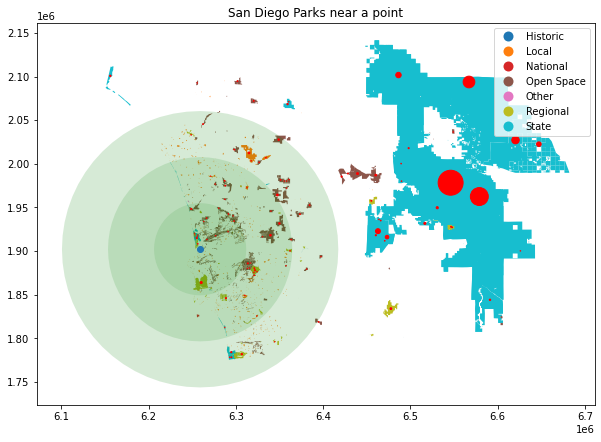

In [7]:
choropelth_field = 'PARK_TYPE'
prop_symbol_field = 'GIS_ACRES'
num_props = 100
buffers = [10,20,30]
maptitle = "San Diego Parks near a point"

#Output map
map_ = map_parks(sd_parks, choropelth_field, prop_symbol_field, num_props, point_gdf, buffers, maptitle)